<a href="https://colab.research.google.com/github/mralamdari/CV-Object-Detection/blob/main/Multi_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import copy
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#1.Data
###Dataset COCO has 80 object categories [COCO](http:/​/cocodataset.​org/​#home)

In [ ]:
# Clone COCO API
!git clone https://github.com/pdollar/coco
!cd coco

!mkdir images
!cd images

In [ ]:
# Download Images
!wget -c https://pjreddie.com/media/files/train2014.zip

!unzip -q train2014.zip

In [ ]:
os.remove('/content/train2014.zip')

In [ ]:
!wget -c https://pjreddie.com/media/files/val2014.zip

# Unzip
!unzip -q val2014.zip

In [ ]:
os.remove('/content/val2014.zip')

In [ ]:
!cd ..

# Download COCO Metadata
# !wget -c https://pjreddie.com/media/files/instances_train-val2014.zip
!wget -c https://pjreddie.com/media/files/coco/5k.part
!wget -c https://pjreddie.com/media/files/coco/trainvalno5k.part
!wget -c https://pjreddie.com/media/files/coco/labels.tgz
!tar xzf labels.tgz
# !unzip -q instances_train-val2014.zip

# Set Up Image Lists
!paste <(awk "{print \"$PWD\"}" <5k.part) 5k.part | tr -d '\t' > 5k.txt
!paste <(awk "{print \"$PWD\"}" <trainvalno5k.part) trainvalno5k.part | tr -d '\t' > trainvalno5k.txt


os.replace('/content/train2014', '/content/images/train2014')
os.replace('/content/val2014', '/content/images/val2014')

os.mkdir('/content/config')
!wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg
os.replace('/content/yolov3.cfg', '/content/config/yolov3.cfg')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class CocoDataset(torch.utils.data.Dataset):
  def __init__(self, path2listfiles, transform=None, trans_params=None):
    with open(path2listfiles, 'r') as f:
      self.path2images = f.readlines()
      self.path2labels = [f"{path[:-4].replace('images', 'labels')}txt" for path in self.path2images]
    self.transform = transform
    self.trans_params = trans_params
    
  def __len__(self):
    return len(self.path2images)
  
  def __getitem__(self, index):
    path2img = self.path2images[index % len(self.path2images)].rstrip()
    img = Image.open(path2img).convert('RGB')
    path2label = self.path2labels[index % len(self.path2labels)].rstrip()
    labels = None
    if os.path.exists(path2label):
      labels = np.loadtxt(path2label).reshape(-1, 5)
    if self.transform:
      img, labels = self.transform(img, labels, self.trans_params)
    return img, labels, path2img

In [ ]:
path2trainList = '/content/trainvalno5k.txt'
coco_train = CocoDataset(path2trainList)

In [ ]:
img, labels, path2img = coco_train[1]

In [ ]:
path2valList = '/content/5k.txt'
coco_val = CocoDataset(path2valList)

In [ ]:
!wget https://gist.githubusercontent.com/AruniRC/7b3dadd004da04c80198557db5da4bda/raw/2f10965ace1e36c4a9dca76ead19b744f5eb7e88/ms_coco_classnames.txt
with open('/content/ms_coco_classnames.txt', 'r') as f:
  names_dict = f.readlines()

coco_names = list()
for name in names_dict[1:]:
  first = name.find("u'") + 2
  second = -name[::-1].find("'") - 1
  coco_names.append(name[first: second])

--2022-03-30 15:15:12--  https://gist.githubusercontent.com/AruniRC/7b3dadd004da04c80198557db5da4bda/raw/2f10965ace1e36c4a9dca76ead19b744f5eb7e88/ms_coco_classnames.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1354 (1.3K) [text/plain]
Saving to: ‘ms_coco_classnames.txt’

ms_coco_classnames. 100%[===================>]   1.32K  --.-KB/s    in 0s      

2022-03-30 15:15:12 (88.1 MB/s) - ‘ms_coco_classnames.txt’ saved [1354/1354]



In [ ]:
coco_names

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [ ]:
def rescale_bbox(bb, W, H):
  x, y, w, h = bb
  return [x*W, y*H, w*W, h*H]

In [ ]:
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')
def show_img_bbox(img, target):
  if torch.is_tensor(img):
    img = torchvision.transforms.functional.to_pil_image(img)
  if torch.is_tensor(target):
    target = target.numpy()[:, 1:]
  W, H = img.size
  draw = ImageDraw.Draw(img)
  
  for t in target:
    id = int(t[0])
    bbox = t[1:]
    bbox = rescale_bbox(bbox, W, H)
    xc, yc, w, h = bbox
    color = [int(c) for c in colors[id]]
    name = coco_names[id]
    draw.rectangle(((xc-w/2, yc-h/2), (xc+w/2, yc+h/2)), outline=tuple(color), width=3)
    draw.text((xc-w/2, yc-h/2), name, dill=(255, 255, 255, 0))
    plt.imshow(np.array(img))

(480, 640) (11, 5)


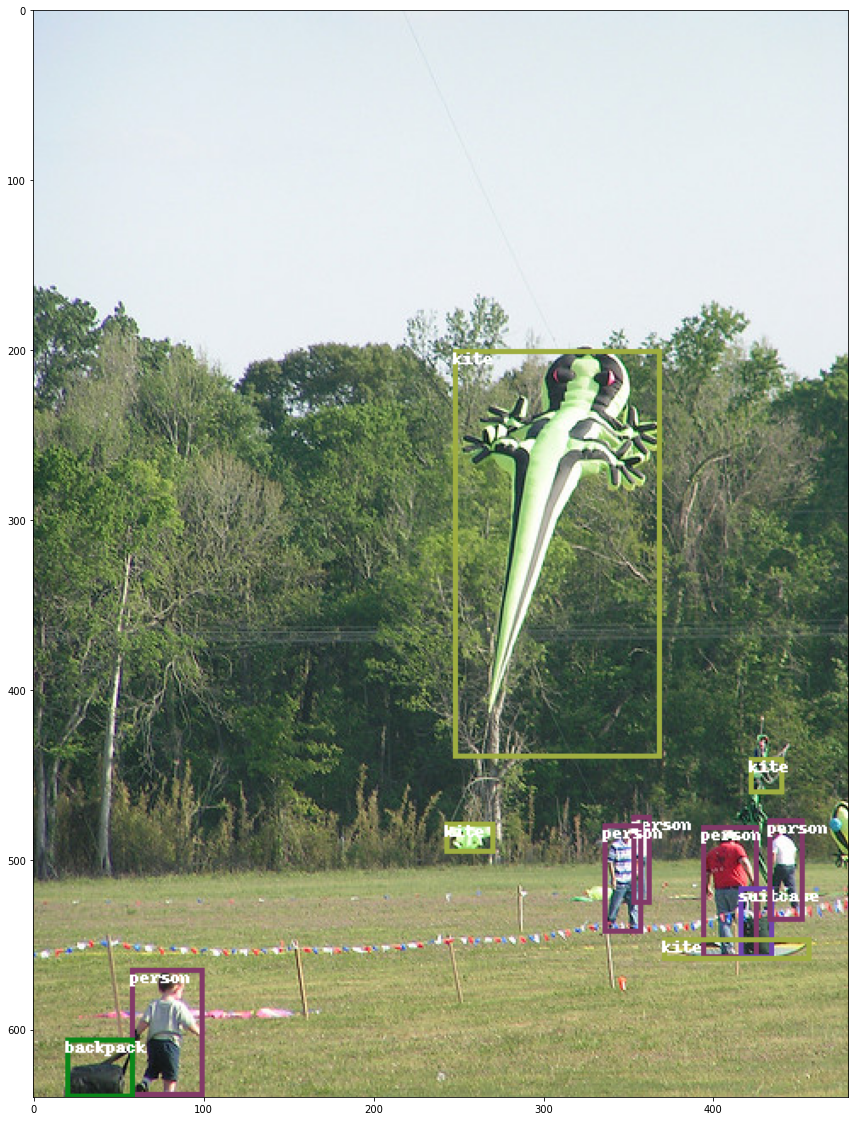

In [ ]:
ind = np.random.randint(len(coco_train))
img, label, path2img = coco_train[ind]
print(img.size, label.shape)
plt.rcParams['figure.figsize'] = (20, 20)
show_img_bbox(img, label)

##TransformS

In [ ]:
def pad_to_square(img, boxes, pad_value=0, normalized_labels=True):

    w, h = img.size
    w_factor, h_factor = (w, h) if normalized_labels else (1, 1)
    dim_diff = np.abs(h - w)
    pad1 = dim_diff // 2
    pad2 = dim_diff - pad1
    
    if h<= w:
      left, top, right, bottom = 0, pad1, 0, pad2
    else:
      left, top, right, bottom = pad1, 0, pad2, 0
    padding = (left, top, right, bottom)
    img_padded = torchvision.transforms.functional.pad(img, padding=padding, fill=pad_value)
    w_padded, h_padded = img_padded.size
    x1 = w_factor * (boxes[:, 1] - boxes[:, 3]/2)
    y1 = h_factor * (boxes[:, 2] - boxes[:, 4]/2)
    x2 = w_factor * (boxes[:, 1] + boxes[:, 3]/2)
    y2 = h_factor * (boxes[:, 2] + boxes[:, 4]/2)

    x1 += padding[0] #left
    y1 += padding[1] #top
    x2 += padding[2] #right
    y2 += padding[3] #bottom
    boxes[:, 1] = ((x1 +  x2)/2) /  w_padded
    boxes[:, 2] = ((y1 +  y2)/2) /  h_padded
    boxes[:, 3] *= w_factor / w_padded
    boxes[:, 4] *= h_factor / h_padded
    return img_padded, boxes

In [ ]:
def hflip(img, label):
  img = torchvision.transforms.functional.hflip(img)
  label[:, 1] = 1.0 - label[:, 1]
  return img, label

In [ ]:
def transformer(img, label, params):
  if params['pad2square']:
    img, label = pad_to_square(img, label)
  
  img = torchvision.transforms.functional.resize(img, params['target_size'])

  if np.random.rand() < params['p_hflip']:
    img, label = hflip(img, label)
  
  img = torchvision.transforms.functional.to_tensor(img)
  targets = torch.zeros((len(label), 6))
  targets[:, 1:] = torch.from_numpy(label)
  return img, targets


In [ ]:
transformer_params_train = {
    'target_size':(416, 416),
    'pad2square': True,
    'p_hflip': 1.0,
    'normalized_labels':True
}
coco_train = CocoDataset(path2trainList, 
                         transform = transformer,
                         trans_params=transformer_params_train)

torch.Size([3, 416, 416]) torch.Size([14, 6])


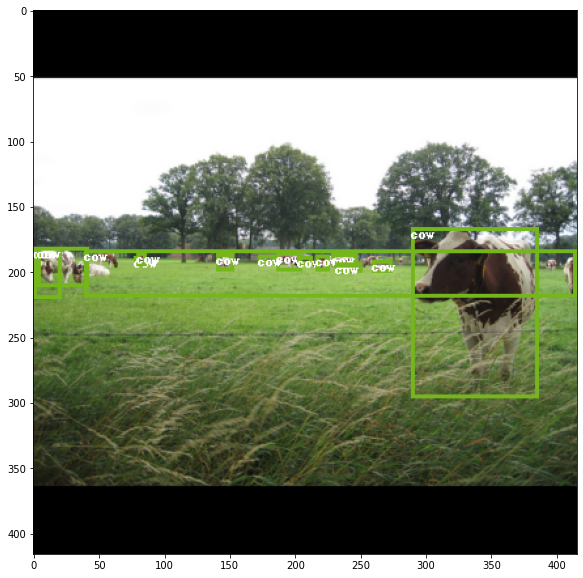

In [ ]:
ind = np.random.randint(len(coco_train))
img, targets, path2img = coco_train[ind]
print(img.shape, targets.shape)
plt.rcParams['figure.figsize'] = (20, 10)
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')
show_img_bbox(img, targets)

In [ ]:
transformer_params_val = {
    'target_size':(416, 416),
    'pad2square': True,
    'p_hflip': 0.0,
    'normalized_labels':True
}
coco_val = CocoDataset(path2valList,
                        transform = transformer,
                        trans_params=transformer_params_val)

torch.Size([3, 416, 416]) torch.Size([14, 6])


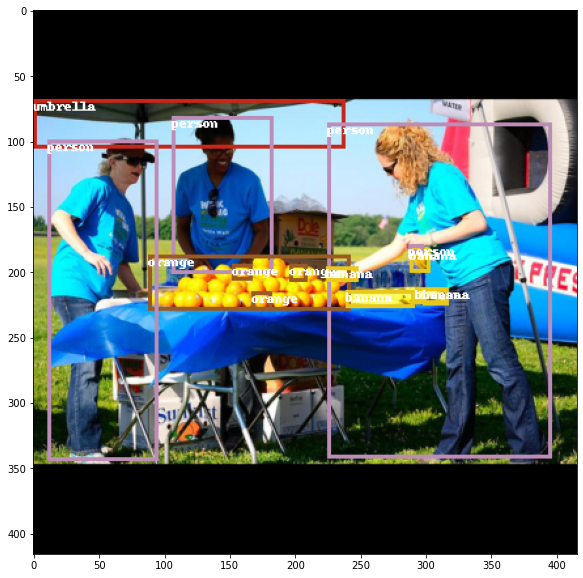

In [ ]:
ind = np.random.randint(len(coco_val))
img, targets, path2img = coco_val[ind]
plt.rcParams['figure.figsize'] = (20, 10)
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')
print(img.shape, targets.shape)
show_img_bbox(img, targets)

##DataLoaders

In [ ]:
def collate_fn(batch):
  imgs, targets, paths = list(zip(*batch))
  targets = [boxes for boxes in targets if boxes is not None]

  for b, boxes in enumerate(targets):
    boxes[:, 0] = b
    targets = torch.cat(targets, 0)
    imgs = torch.stack([img for img in imgs])
    return imgs, targets, paths

In [ ]:
batch_size=8
train_dl = torch.utils.data.DataLoader(coco_train,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=0,
                                       pin_memory=True,
                                       collate_fn=collate_fn)


In [ ]:
for imgs_batch, tg_batch, path_batch in train_dl:
  break
print(imgs_batch.shape, tg_batch.shape, tg_batch.dtype)

torch.Size([8, 3, 416, 416]) torch.Size([43, 6]) torch.float32


In [ ]:
batch_size=8
val_dl = torch.utils.data.DataLoader(coco_train,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=0,
                                       pin_memory=True,
                                       collate_fn=collate_fn)


In [ ]:
for imgs_batch, tg_batch, path_batch in val_dl:
  break
print(imgs_batch.shape, tg_batch.shape, tg_batch.dtype)

torch.Size([8, 3, 416, 416]) torch.Size([33, 6]) torch.float32


#2.Model

In [ ]:
# !wget https://github.com/PacktPublishing/PyTorch-Computer-Vision-Cookbook/blob/master/Chapter05/myutils.py

def parse_model_config(path2file):
    with open(path2file, 'r') as f:
      lines = f.read().split('\n')
 
    lines = [x.rstrip().lstrip() for x in lines if x and not x.startswith('#')]
    
    blocks_list = []
    for line in lines:
        # start of a new block
        if line.startswith('['): 
            blocks_list.append({})
            blocks_list[-1]['type'] = line[1:-1].rstrip()
            
        else:
            key, value = line.split("=")
            blocks_list[-1][key.rstrip()] = value.strip()

    return blocks_list


def create_layers(blocks_list):
    hyperparams = blocks_list[0]
    channels_list = [int(hyperparams["channels"])]
    module_list = nn.ModuleList()
    
    for layer_ind, layer_dict in enumerate(blocks_list[1:]):
        modules = nn.Sequential()
        
        if layer_dict["type"] == "convolutional":
            filters = int(layer_dict["filters"])
            kernel_size = int(layer_dict["size"])
            pad = (kernel_size - 1) // 2
            bn=layer_dict.get("batch_normalize",0)    
            
            
            conv2d= nn.Conv2d(
                        in_channels=channels_list[-1],
                        out_channels=filters,
                        kernel_size=kernel_size,
                        stride=int(layer_dict["stride"]),
                        padding=pad,
                        bias=not bn)
            modules.add_module(f"conv_{layer_ind}", conv2d)
            
            if bn:
                bn_layer = nn.BatchNorm2d(filters,momentum=0.9, eps=1e-5)
                modules.add_module(f"batch_norm_{layer_ind}", bn_layer)
                
                
            if layer_dict["activation"] == "leaky":
                activn = nn.LeakyReLU(0.1)
                modules.add_module(f"leaky_{layer_ind}", activn)
                
        elif layer_dict["type"] == "upsample":
            stride = int(layer_dict["stride"])
            upsample = nn.Upsample(scale_factor = stride)
            modules.add_module(f"upsample_{layer_ind}", upsample) 
            
        elif layer_dict["type"] == "shortcut":
            backwards=int(layer_dict["from"])
            filters = channels_list[1:][backwards]
            modules.add_module(f"shortcut_{layer_ind}", EmptyLayer())
            
        elif layer_dict["type"] == "route":
            layers = [int(x) for x in layer_dict["layers"].split(",")]
            filters = sum([channels_list[1:][l] for l in layers])
            modules.add_module(f"route_{layer_ind}", EmptyLayer())
            
        elif layer_dict["type"] == "yolo":
            anchors = [int(a) for a in layer_dict["anchors"].split(",")]
            anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]

            mask = [int(m) for m in layer_dict["mask"].split(",")]
            anchors = [anchors[i] for i in mask]
            
            num_classes = int(layer_dict["classes"])
            img_size = int(hyperparams["height"])
            
            yolo_layer = YOLOLayer(anchors, num_classes, img_size)
            modules.add_module(f"yolo_{layer_ind}", yolo_layer)
            
        module_list.append(modules)       
        channels_list.append(filters)

    return hyperparams, module_list        



class EmptyLayer(nn.Module):
    def __init__(self):
        super(EmptyLayer, self).__init__()
        
        
class YOLOLayer(nn.Module):

    def __init__(self, anchors, num_classes, img_dim=416):
        super(YOLOLayer, self).__init__()
        self.anchors = anchors
        self.num_anchors = len(anchors)
        self.num_classes = num_classes
        self.img_dim = img_dim
        self.grid_size = 0 
        
        
    def forward(self, x_in):
        batch_size = x_in.size(0)
        grid_size = x_in.size(2)
        devide=x_in.device
        
        prediction=x_in.view(batch_size, self.num_anchors, 
                             self.num_classes + 5, grid_size, grid_size)
        prediction=prediction.permute(0, 1, 3, 4, 2)
        prediction=prediction.contiguous()
        
        obj_score = torch.sigmoid(prediction[..., 4]) 
        pred_cls = torch.sigmoid(prediction[..., 5:]) 
        
        if grid_size != self.grid_size:
            self.compute_grid_offsets(grid_size, cuda=x_in.is_cuda)
            
        pred_boxes=self.transform_outputs(prediction) 
        
        output = torch.cat(
            (
                pred_boxes.view(batch_size, -1, 4),
                obj_score.view(batch_size, -1, 1),
                pred_cls.view(batch_size, -1, self.num_classes),
            ), -1,)
        return output        
    
    
        
    def compute_grid_offsets(self, grid_size, cuda=True):
        self.grid_size = grid_size
        self.stride = self.img_dim / self.grid_size
        
        self.grid_x = torch.arange(grid_size, device=device).repeat(1, 1, grid_size, 1 ).type(torch.float32)
        self.grid_y = torch.arange(grid_size, device=device).repeat(1, 1, grid_size, 1).transpose(3, 2).type(torch.float32)
        
        scaled_anchors=[(a_w / self.stride, a_h / self.stride) for a_w, a_h in self.anchors]
        self.scaled_anchors=torch.tensor(scaled_anchors,device=device)
        
        self.anchor_w = self.scaled_anchors[:, 0:1].view((1, self.num_anchors, 1, 1))
        self.anchor_h = self.scaled_anchors[:, 1:2].view((1, self.num_anchors, 1, 1))
        
        
        
    def transform_outputs(self,prediction):
        device=prediction.device
        x = torch.sigmoid(prediction[..., 0]) # Center x
        y = torch.sigmoid(prediction[..., 1]) # Center y
        w = prediction[..., 2] # Width
        h = prediction[..., 3] # Height

        pred_boxes = torch.zeros_like(prediction[..., :4]).to(device)
        pred_boxes[..., 0] = x.data + self.grid_x
        pred_boxes[..., 1] = y.data + self.grid_y
        pred_boxes[..., 2] = torch.exp(w.data) * self.anchor_w
        pred_boxes[..., 3] = torch.exp(h.data) * self.anchor_h
        
        return pred_boxes * self.stride  

In [ ]:
path2config="/content/config/yolov3.cfg"
blocks_list = parse_model_config(path2config)
blocks_list

In [ ]:
class Darknet(nn.Module):
  def __init__(self, config_path, img_size=416):
    super(Darknet, self).__init__()
    self.blocks_list = parse_model_config(config_path)
    self.hyperparams, self.module_list = create_layers(self.blocks_list)
    self.img_size = img_size
  
  def forward(self, x):
    img_dim = x.shape[2]
    layer_outputs, yolo_outputs = [], []
    for block, module in zip(self.blocks_list[1:], self.module_list):
      if block['type'] in ['convolutional', 'upsample', 'maxpool']:
        x = module(x)
      elif block['type'] == 'shortcut':
        layer_ind = int(block['from'])
        x = layer_outputs[-1] + layer_outputs[layer_ind]
      elif block['type'] == 'yolo':
        x = module[0](x)
        yolo_outputs.append(x)
      elif block['type'] == 'route':
        x = torch.cat([layer_outputs[int(l)] for l in block['layers'].split(',')], 1)
      layer_outputs.append(x)
    
    yolo_out_cat = torch.cat(yolo_outputs, 1)
    return yolo_out_cat, yolo_outputs

In [ ]:
model = Darknet(path2config).to(device)

In [ ]:
print(model)

In [ ]:
with torch.no_grad():
  dummy_out_cat, dummy_out = model(torch.rand(1, 3, 416, 416).to(device))
  print(dummy_out_cat.shape, dummy_out[0].shape, dummy_out[1].shape, dummy_out[2].shape)

torch.Size([1, 10647, 85]) torch.Size([1, 507, 85]) torch.Size([1, 2028, 85]) torch.Size([1, 8112, 85])


#3.Loss

In [ ]:
def get_loss_batch(output,targets, params_loss, opt=None):
    ignore_thres = params_loss['ignore_thres']
    scaled_anchors = params_loss['scaled_anchors']
    mse_loss = params_loss['mse_loss']
    bce_loss = params_loss['bce_loss']
    num_yolos = params_loss['num_yolos']
    num_anchors = params_loss['num_anchors']
    obj_scale = params_loss['obj_scale']
    noobj_scale = params_loss['noobj_scale']

    loss = 0.0
    for yolo_ind in range(num_yolos):
      yolo_out = output[yolo_ind]
      batch_size, num_bboxs, _ = yolo_out.shape
      gz_s = num_bboxs / num_anchors
      grid_size = int(np.sqrt(gz_s))

    yolo_out = yolo_out.view(batch_size, num_anchors, grid_size, grid_size,-1)
    pred_boxes = yolo_out[:,:,:,:,:4]
    x, y, w, h = transform_bbox(pred_boxes, scaled_anchors[yolo_ind])
    pred_conf = yolo_out[:,:,:,:,4]
    pred_cls_prob = yolo_out[:,:,:,:,5:]
    yolo_targets = get_yolo_targets({
        'pred_cls_prob': pred_cls_prob,
        'pred_boxes': pred_boxes,
        'targets': targets,
        'anchors': scaled_anchors[yolo_ind],
        'ignore_thres': ignore_thres
    })

    obj_mask = yolo_targets['obj_mask']
    noobj_mask = yolo_targets['noobj_mask']
    tx = yolo_targets['tx']
    ty = yolo_targets['ty']
    tw = yolo_targets['tw']
    th = yolo_targets['th']
    tcls = yolo_targets['tcls']
    t_conf = yolo_targets['t_conf']


    loss_x = mse_loss(x[obj_mask], tx[obj_mask])
    loss_y = mse_loss(y[obj_mask], ty[obj_mask])
    loss_w = mse_loss(w[obj_mask], tw[obj_mask])
    loss_h = mse_loss(h[obj_mask], th[obj_mask])

    loss_conf_obj = bce_loss(pred_conf[obj_mask], t_conf[obj_mask])
    loss_conf_noobj = bce_loss(pred_conf[noobj_mask], t_conf[noobj_mask])
    loss_conf = obj_scale * loss_conf_obj + noobj_scale * loss_conf_noobj
    loss_cls = bce_loss(pred_cls_prob[obj_mask], tcls[obj_mask])
    loss += loss_x + loss_y + loss_w + loss_h + loss_conf + loss_cls

    if opt is not None:
      opt.zero_grad()
      loss.backward()
      opt.step()
    return loss.item()

In [ ]:
def transform_bbox(bbox, anchors):
  x = bbox[:,:,:,:,0]
  y = bbox[:,:,:,:,1]
  w = bbox[:,:,:,:,2]
  h = bbox[:,:,:,:,3]
  anchors_w = anchors[:, 0].view((1, 3, 1, 1))
  anchors_h = anchors[:, 1].view((1, 3, 1, 1))
  x = x - x.floor()
  y = y - y.floor()
  w = torch.log(w / anchors_w + 1e-16)
  h = torch.log(h / anchors_h + 1e-16)
  return x, y, w, h

In [ ]:
def get_yolo_targets(params):
    pred_boxes = params['pred_boxes']
    pred_cls_prob = params['pred_cls_prob']
    target = params['targets']
    anchors = params['anchors']
    ignore_thres = params['ignore_thres']

    batch_size = pred_boxes.size(0)
    num_anchors = pred_boxes.size(1)
    grid_size = pred_boxes.size(2)
    num_cls = pred_cls_prob.size(-1)

    sizeT = batch_size, num_anchors, grid_size, grid_size
    obj_mask = torch.zeros(sizeT, device=device, dtype=torch.uint8)
    noobj_mask = torch.ones(sizeT, device=device, dtype=torch.uint8)
    tx = torch.zeros(sizeT, device=device, dtype=torch.float32)
    ty = torch.zeros(sizeT, device=device, dtype=torch.float32)
    tw = torch.zeros(sizeT, device=device, dtype=torch.float32)
    th = torch.zeros(sizeT, device=device, dtype=torch.float32)

    sizeT = batch_size, num_anchors, grid_size, grid_size, num_cls
    tcls = torch.zeros(sizeT, device=device, dtype=torch.float32)


    target_bboxes = target[:, 2:] * grid_size
    t_xy = target_bboxes[:, :2]
    t_wh = target_bboxes[:, 2:]
    t_x, t_y = t_xy.t()
    t_w, t_h = t_wh.t()

    grid_i, grid_j = t_xy.long().t()
    
    iou_with_anchors = [get_iou_WH(anchor, t_wh) for anchor in anchors]
    iou_with_anchors = torch.stack(iou_with_anchors)
    best_iou_wa, best_anchor_ind = iou_with_anchors.max(0)
    
    batch_inds, target_labels = target[:, :2].long().t()
    obj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 1
    noobj_mask[batch_inds, best_anchor_ind, grid_j, grid_i] = 0

    for ind, iou_wa in enumerate(iou_with_anchors.t()):
        noobj_mask[batch_inds[ind], iou_wa > ignore_thres, grid_j[ind], grid_i[ind]] = 0
        
        
    tx[batch_inds, best_anchor_ind, grid_j, grid_i] = t_x - t_x.floor()
    ty[batch_inds, best_anchor_ind, grid_j, grid_i] = t_y - t_y.floor()
    

    anchor_w=anchors[best_anchor_ind][:, 0]
    tw[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_w / anchor_w + 1e-16)
    
    anchor_h=anchors[best_anchor_ind][:, 1]
    th[batch_inds, best_anchor_ind, grid_j, grid_i] = torch.log(t_h / anchor_h + 1e-16)
    
    tcls[batch_inds, best_anchor_ind, grid_j, grid_i, target_labels] = 1
    
    output={
        "obj_mask" : obj_mask,
        "noobj_mask" : noobj_mask,
        "tx": tx,
        "ty": ty,
        "tw": tw,
        "th": th,
        "tcls": tcls,
        "t_conf": obj_mask.float(),
    }
    return output

In [ ]:
def get_iou_WH(wh1, wh2):
  wh2 = wh2.t()
  w1, h1 = wh1[0], wh1[1]
  w2, h2 = wh2[0], wh2[1]
  inter_area = torch.min(w1, w2) * torch.min(h1, h2)
  union_area = (w1 * h1 + 1e-16) + w2 * h2 - inter_area
  return inter_area / union_area

#4.Training the Model


In [ ]:
def loss_epoch(model, params_loss, dataset_dl, sanity_check=False, opt=None):
  running_loss=0.0
  len_data = len(dataset_dl.dataset)
  running_metrics = {}
  for x, y, _ in dataset_dl:
    y = y.to(device)
    _, output = model(x.to(device))
    loss = get_loss_batch(output, y, params_loss, opt)
    running_loss += loss
    if sanity_check is True:
      break
  total_loss = running_loss / float(len_data)
  return total_loss

In [ ]:
def train_val(model, params):
  num_epochs = params['num_epochs']
  params_loss = params['params_loss']
  opt = params['optimizer']
  train_dl = params['train_dl']
  val_dl = params['val_dl']
  sanity_check = params['sanity_check']
  lr_scheduler = params['lr_scheduler']
  path2weights = params['path2weights']

  loss_history = {'train': [], 'val': []}

  best_model_wts =copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print(f'Epoch {epoch+1}/{num_epochs}, current lr={current_lr}') 

    model.train()
    train_loss = loss_epoch(model, params_loss, train_dl, sanity_check, opt)
    loss_history['train'].append(train_loss)

    model.eval()
    val_loss = loss_epoch(model, params_loss, val_dl, sanity_check)
    loss_history['val'].append(val_loss)

    print(f"train loss: {train_loss:.6f} ,val loss: {val_loss:.6f}")    


    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print('The Best Model has been Saved')
  
    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      model.load_state_dict(best_model_wts)

  print("-"*10) 
  model.load_state_dict(best_model_wts)
  return model, loss_history

In [ ]:
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', factor=0.5, patience=20, verbose=1)

path2model = '/content/models'
if not os.path.exists(path2model):
  os.mkdir(path2model)

scaled_anchors = [model.module_list[82][0].scaled_anchors,
                  model.module_list[94][0].scaled_anchors,
                  model.module_list[106][0].scaled_anchors]

In [ ]:
mse_loss = torch.nn.MSELoss(reduction='sum')
bce_loss = torch.nn.BCELoss(reduction='sum')
params_loss={
    "scaled_anchors" : scaled_anchors,
    "ignore_thres": 0.5,
    "mse_loss": mse_loss,
    "bce_loss": bce_loss,
    "num_yolos": 3,
    "num_anchors": 3,
    "obj_scale": 1,
    "noobj_scale": 100,
} 
params_train={
    "num_epochs": 10,
    "optimizer": opt,
    "params_loss": params_loss,
    "train_dl": train_dl,
    "val_dl": val_dl,
    "sanity_check": True,
    "lr_scheduler": lr_scheduler,
    "path2weights": path2model+"/weights.pt",
}
model,loss_hist=train_val(model,params_train)

Epoch 1/10, current lr=0.001
train loss: 1.475218 ,val loss: 1.399261
The Best Model has been Saved
Epoch 2/10, current lr=0.001
train loss: 1.459474 ,val loss: 1.422837
Epoch 3/10, current lr=0.001
train loss: 1.432054 ,val loss: 1.459575
Epoch 4/10, current lr=0.001
train loss: 1.354469 ,val loss: 1.402750
Epoch 5/10, current lr=0.001
train loss: 1.329675 ,val loss: 1.330180
The Best Model has been Saved
Epoch 6/10, current lr=0.001
train loss: 1.288033 ,val loss: 1.302544
The Best Model has been Saved
Epoch 7/10, current lr=0.001
train loss: 1.237442 ,val loss: 1.264662
The Best Model has been Saved
Epoch 8/10, current lr=0.001
train loss: 1.215102 ,val loss: 1.194263
The Best Model has been Saved
Epoch 9/10, current lr=0.001
train loss: 1.163458 ,val loss: 1.142297
The Best Model has been Saved
Epoch 10/10, current lr=0.001
train loss: 1.144445 ,val loss: 1.099056
The Best Model has been Saved
----------


#5.Deploy

In [ ]:
path2weights = '/content/models/weights.pt'
model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
  out, _ = model(img.unsqueeze(0).to(device))

In [ ]:
def NonMaxSuppression(bbox_pred, obj_threshold=0.5, nms_thres=0.5):
  bbox_pred[..., :4] = xywh2xyxy(bbox_pred[..., :4])
  output = [None] * len(bbox_pred)

  for ind, bb_pre in enumerate(bbox_pred):
    bb_pr = bb_pre[bb_pre[:, 4] >= obj_threshold]
    if not bb_pr.size(0):
      continue

    score = bb_pr[:, 4] * bb_pr[:, 5:].max(1)[0]
    bb_pr = bb_pr[(-score).argsort()]

    cls_probs, cls_preds = bb_pr[:, 5:].max(1, keepdim=True)
    detections = torch.cat((bb_pr[:, :5], cls_probs.float(), cls_preds.float()), 1)

    bbox_nms = []
    while detections.size(0):
      high_iou_inds = bbox_iou(detections[0, :4].unsqueeze(0),detections[:, :4]) > nms_thres
      cls_match_inds = detections[0, -1] == detections[:, -1]
      supp_inds = high_iou_inds & cls_match_inds
      ww = detections[supp_inds, 4]
      detections[0, :4] = (ww.view(len(ww), 1) * detections[supp_inds, :4]).sum(0) / ww.sum()

      bbox_nms += [detections[0]]
      detections = detections[~supp_inds]

      if bbox_nms:
        output[ind] = torch.stack(bbox_nms)
        output[ind] = xyxyh2xywh(output[ind])

In [ ]:
img_size=416
out_nms = NonMaxSuppression(out.cpu())
print(out_nms[0].shape)

In [ ]:
def xywh2xyxy(xywh):
  xyxy = xywh.new(xywh.shape)
  xyxy[..., 0] = xywh[..., 0] - xywh[..., 2] / 2.0
  xyxy[..., 1] = xywh[..., 1] - xywh[..., 3] / 2.0
  xyxy[..., 2] = xywh[..., 0] + xywh[..., 2] / 2.0
  xyxy[..., 3] = xywh[..., 1] + xywh[..., 3] / 2.0
  return xyxy

In [ ]:
def xyxyh2xywh(xyxy, img_size=416):
  xywh = torch.zeros(xyxy.shape[0], 6)
  xywh[:, 2] = (xyxy[:, 0] + xyxy[:, 2]) / 2.0 / img_size
  xywh[:, 3] = (xyxy[:, 1] + xyxy[:, 3]) / 2.0 / img_size
  xywh[:, 4] = (xyxy[:, 2] - xyxy[:, 0]) / img_size
  xywh[:, 5] = (xyxy[:, 3] - xyxy[:, 1]) / img_size
  xywh[:, 1] = xyxy[:, 6]
  return xywh

In [ ]:
def bbox_iou(box1, box2):
  b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
  b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

  inter_rect_x1 = torch.max(b1_x1, b2_x1)
  inter_rect_y1 = torch.max(b1_y1, b2_y1)
  inter_rect_x2 = torch.max(b1_x2, b2_x2)
  inter_rect_y2 = torch.max(b1_y2, b2_y2)

  inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)

  b1_area = (b1_x2 - b1_x1 + 1.0) * (b1_y2 - b1_y1 + 1.0)
  b2_area = (b2_x2 - b2_x1 + 1.0) * (b2_y2 - b2_y1 + 1.0)

  iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)
  return iou

torch.Size([3, 416, 416])
torch.Size([2, 6])
torch.Size([1, 10647, 85])


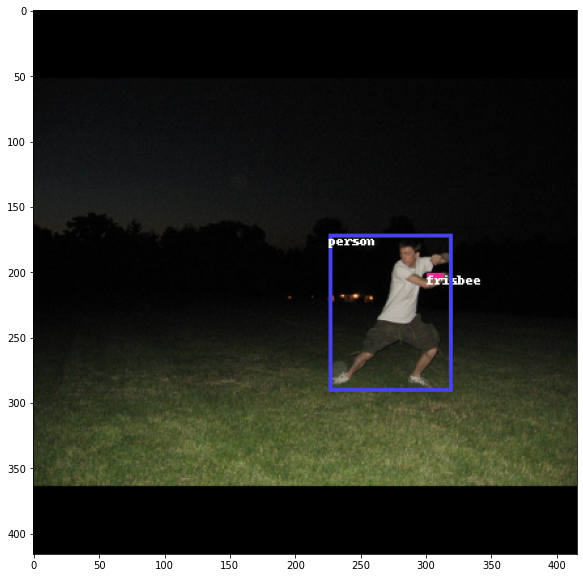

In [ ]:
img,tg,_=coco_val[4]
print(img.shape)
print(tg.shape)
show_img_bbox(img,tg)
model.eval()
with torch.no_grad():
    out,_=model(img.unsqueeze(0).to(device))
print(out.shape)

In [ ]:
img_size=416
out_nms = NonMaxSuppression(out.cpu())
print(out_nms[0].shape)

#6.Using PreTrained Yolo v5 Algorithm

In [ ]:
!pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt  # install dependencies

In [ ]:
!wget https://gist.githubusercontent.com/AruniRC/7b3dadd004da04c80198557db5da4bda/raw/2f10965ace1e36c4a9dca76ead19b744f5eb7e88/ms_coco_classnames.txt
with open('/content/ms_coco_classnames.txt', 'r') as f:
  names_dict = f.readlines()

coco_names = list()
for name in names_dict[1:]:
  first = name.find("u'") + 2
  second = -name[::-1].find("'") - 1
  coco_names.append(name[first: second])

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

!wget https://ultralytics.com/images/zidane.jpg
img = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

results = model(img)
results.pandas().xyxy[0]

In [ ]:
img=plt.imread('/content/zidane.jpg')
image=torch.from_numpy(img.transpose((2, 0, 1)))
image = torchvision.transforms.functional.to_pil_image(image)

new_tg = results.pandas().xyxy[0].drop(columns=['name'])
new_t = torch.from_numpy(np.array(new_tg))

In [ ]:
draw = ImageDraw.Draw(image)
colors = np.random.randint(0, 255, size=(80, 3), dtype='uint8')
for t in new_t:
  id = int(t[-1])
  bbox = t[:-2]
  xc, yc, w, h = bbox
  color = [int(c) for c in colors[id]]
  name = coco_names[id]
  draw.rectangle(((xc-w/2, yc-h/2), (xc+w/2, yc+h/2)), outline=tuple(color), width=3)
  draw.text((xc-w/2, yc-h/2), name, dill=(255, 255, 255, 0))
  plt.imshow(np.array(image))

(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
(720, 1280, 3)
